In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/gtd/globalterrorismdb_0718dist.csv


In [75]:
import pandas as pd
data = pd.read_csv("../input/gtd/globalterrorismdb_0718dist.csv",encoding="ISO-8859-1")#read csv file

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data

In [76]:
nd=data[["vicinity","crit1","crit2","crit3","multiple","suicide","property","ishostkid","ransom","targtype1","attacktype1","weaptype1"]]#considering the attributes

In [77]:
nd["ransom"].fillna(0)
nd["ishostkid"].fillna(0)
nd["crit1"].fillna(0)
nd["crit2"].fillna(0)
nd["crit3"].fillna(0)
nd["multiple"].fillna(0)
nd["suicide"].fillna(0)
nd["property"].fillna(0)
nd["ransom"].fillna(0)
nd["ishostkid"].fillna(0)
nd["targtype1"].fillna(1)
nd["attacktype1"].fillna(1)
nd["weaptype1"].fillna(1)

0         13
1         13
2         13
3          6
4          8
          ..
181686     5
181687     6
181688     8
181689     6
181690     6
Name: weaptype1, Length: 181691, dtype: int64

In [78]:
#data cleaning
for i in range(181691):
    if (nd["ransom"][i]!=0.0) and (nd["ransom"][i]!=1):
        nd["ransom"][i]=0
    if (nd["vicinity"][i]!=0.0) and (nd["vicinity"][i]!=1):
        nd["vicinity"][i]=0
    if (nd["ishostkid"][i]!=0.0) and (nd["ishostkid"][i]!=1):
        nd["ishostkid"][i]=0

nd.columns

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/cond

Index(['vicinity', 'crit1', 'crit2', 'crit3', 'multiple', 'suicide',
       'property', 'ishostkid', 'ransom', 'targtype1', 'attacktype1',
       'weaptype1'],
      dtype='object')

In [79]:
nd["ishostkid"].unique()#cross check

array([0., 1.])

In [80]:
cat_vars=['targtype1','attacktype1','weaptype1'] #one hot encoding 
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(nd[var], prefix=var)
    data1=nd.join(cat_list)
    nd=data1

In [81]:
nd.columns
suc=data[["success"]]
suc.shape

(181691, 1)

In [82]:
nd.columns.values

array(['vicinity', 'crit1', 'crit2', 'crit3', 'multiple', 'suicide',
       'property', 'ishostkid', 'ransom', 'targtype1', 'attacktype1',
       'weaptype1', 'targtype1_1', 'targtype1_2', 'targtype1_3',
       'targtype1_4', 'targtype1_5', 'targtype1_6', 'targtype1_7',
       'targtype1_8', 'targtype1_9', 'targtype1_10', 'targtype1_11',
       'targtype1_12', 'targtype1_13', 'targtype1_14', 'targtype1_15',
       'targtype1_16', 'targtype1_17', 'targtype1_18', 'targtype1_19',
       'targtype1_20', 'targtype1_21', 'targtype1_22', 'attacktype1_1',
       'attacktype1_2', 'attacktype1_3', 'attacktype1_4', 'attacktype1_5',
       'attacktype1_6', 'attacktype1_7', 'attacktype1_8', 'attacktype1_9',
       'weaptype1_1', 'weaptype1_2', 'weaptype1_3', 'weaptype1_5',
       'weaptype1_6', 'weaptype1_7', 'weaptype1_8', 'weaptype1_9',
       'weaptype1_10', 'weaptype1_11', 'weaptype1_12', 'weaptype1_13'],
      dtype=object)

In [97]:
X = nd.loc[:, nd.columns != 'success']

In [98]:
y = suc.loc[:, suc.columns == 'success']

In [85]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [99]:
os = SMOTE(random_state=0)#upsampling using smote
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
columns = X_train.columns

In [87]:
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['success'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['success']==0]))
print("Number of subscription",len(os_data_y[os_data_y['success']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['success']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['success']==1])/len(os_data_X))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  258708
Number of no subscription in oversampled data 129354
Number of subscription 129354
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [46]:
os_data_y.shape

(258708, 1)

In [88]:
data_final_vars=nd.columns.values.tolist()#Recursive feature elimination
y=['success']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 35)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[False  True  True False False False False  True  True False False False
  True False False False  True  True  True False False False  True  True
  True  True False  True  True False False  True  True False  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True False  True]
[21  1  1 20 12  5 14  1  1 19 15  6  1 13  3 10  1  1  1  8  9 11  1  1
  1  1  2  1  1  7 17  1  1 16  1  1  1  1  1  1  1  1  1  1 18  1  1  1
  1  1  1  1  1  4  1]


In [89]:
os_data_X.columns #columns which are formed

Index(['vicinity', 'crit1', 'crit2', 'crit3', 'multiple', 'suicide',
       'property', 'ishostkid', 'ransom', 'targtype1', 'attacktype1',
       'weaptype1', 'targtype1_1', 'targtype1_2', 'targtype1_3', 'targtype1_4',
       'targtype1_5', 'targtype1_6', 'targtype1_7', 'targtype1_8',
       'targtype1_9', 'targtype1_10', 'targtype1_11', 'targtype1_12',
       'targtype1_13', 'targtype1_14', 'targtype1_15', 'targtype1_16',
       'targtype1_17', 'targtype1_18', 'targtype1_19', 'targtype1_20',
       'targtype1_21', 'targtype1_22', 'attacktype1_1', 'attacktype1_2',
       'attacktype1_3', 'attacktype1_4', 'attacktype1_5', 'attacktype1_6',
       'attacktype1_7', 'attacktype1_8', 'attacktype1_9', 'weaptype1_1',
       'weaptype1_2', 'weaptype1_3', 'weaptype1_5', 'weaptype1_6',
       'weaptype1_7', 'weaptype1_8', 'weaptype1_9', 'weaptype1_10',
       'weaptype1_11', 'weaptype1_12', 'weaptype1_13'],
      dtype='object')

In [90]:
arr=[]
for i in range(len(os_data_X.columns)):
    if(rfe.support_[i]==True):
        arr.append(os_data_X.columns[i])

In [91]:
Xt=os_data_X[arr]
Xt.shape

(258708, 35)

In [92]:
yt=os_data_y
yt.shape

(258708, 1)

In [93]:
import statsmodels.api as sm
logit_model=sm.Logit(yt,Xt)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.576529
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.168      
Dependent Variable: success          AIC:              298375.2007
Date:               2019-11-24 05:27 BIC:              298741.4216
No. Observations:   258708           Log-Likelihood:   -1.4915e+05
Df Model:           34               LL-Null:          -1.7932e+05
Df Residuals:       258673           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
crit1            -0.3479   0.0479   -7.2623 0.0000 -0.4417 -0.2540
crit2            -0.6742   0.0677   -9.9554 0.0000 -0

In [100]:
from sklearn.linear_model import LogisticRegression #fitting logistic regression
from sklearn import metrics
X_train, X_test1, y_train, y_test1 = train_test_split(Xt, yt, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [102]:
y_pred = logreg.predict(X_test1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test1, y_test1)))

Accuracy of logistic regression classifier on test set: 0.68


In [103]:
yt.shape

(258708, 1)

In [104]:
cnt=0
for i in range(len(yt["success"])):
    if(yt["success"][i]==1):
        cnt=cnt+1
print(cnt)

129354


In [106]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test1, y_pred)
print(confusion_matrix)#confusion matrix

[[20076 18688]
 [ 6203 32646]]


In [107]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [36339, 77613]

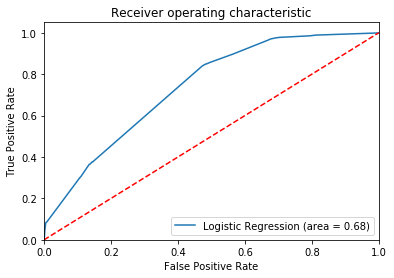

In [27]:
import matplotlib.pyplot as plt# ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()